# Custom Federated Algorithms with the Federated Core API

In this tutorial, we introduce the Federated Core (FC), a set of lower-level
interfaces that can be used to implement custom types of federated algorithms,
and we show how one can implement a simplified version of federated training and
evaluation in terms of these lower-level interfaces.

The tutorial is designed to be self-contained, but it builds concepts
systematically in a bottom-up fashion, and somewhat in-depth. We encourage the
reader to first skim over
[Federated Learning for Image Classification](federated_learning_for_image_classification.md)
for a higher-level and more gentle introduction to the TensorFlow Federated
framework.

## Before we start

Before we start, try to run the following "Hello World" example to make sure
your environment is correctly setup. If it doesn't work, please refer to the
[Installation](../install.md) guide for instructions.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import range
import tensorflow as tf

from tensorflow_federated import python as tff

tf.enable_resource_variables()

@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

'Hello, World!'

## Federated data

One of the distinguishing features of TFF is that it allows you to compactly
express TensorFlow-based computations on *federated data*. We will be using the
term *federated data* in this tutorial to refer to a collection of data items
hosted across a group of devices in a distributed system. For example,
applications running on mobile devices may collect data and store it locally,
without uploading to a centralized location. Or, an array of distributed sensors
may collect and store temperature readings at their locations.

Federated data like those in the above examples are treated in TFF as
[first-class citizens](https://en.wikipedia.org/wiki/First-class_citizen), i.e.,
they may appear as parameters and results of functions, and they have types. To
reinforce this notion, we will refer to federated data sets as *federated
values*, or as *values of federated types*.

The important point to understand is that we are modeling the entire collection
of data items across all devices (e.g., the entire collection temperature
readings from all sensors in a distributed array) as a single federated value.

For example, here's how one would define in TFF the type of a *federated float*
hosted by a group of client devices. A collection of temperature readings that
materialize across an array of distributed sensors could be modeled as a value
of this federated type.

In [0]:
federated_float_on_clients = tff.FederatedType(tf.float32, tff.CLIENTS)

More generally, a federated type in TFF is defined by specifying the type `T` of
its *member constituents* - the items of data that reside on individual devices,
and the group `G` of devices on which federated values of this type are hosted
(plus a third, optional bit of information we'll mention shortly). We refer to
the group `G` of devices hosting a federated value as the value's *placement*.
Thus, `tff.CLIENTS` is an example of a placement.

In [0]:
str(federated_float_on_clients.member)

'float32'

In [0]:
str(federated_float_on_clients.placement)

'CLIENTS'

A federated type with member constituents `T` and placement `G` can be
represented compactly as `{T}@G`, as shown below.

In [0]:
str(federated_float_on_clients)

'{float32}@CLIENTS'

The curly braces `{}` in this concise notation serve as a reminder that the
member constituents (items of data on different devices) may differ, as you
would expect e.g., of temperature sensor readings, so the clients as a group are
jointly hosting a [multi-set](https://en.wikipedia.org/wiki/Multiset) of
`T`-typed items that together constitute the federated value.

Federated types in TFF come in two flavors: those where the member constituents
of a federated value may differ (as just seen above), and those where they are
known to be all equal. This is controlled by the third, optional `all_equal`
parameter in the `tff.FederatedType` constructor (defaulting to `False`).

In [0]:
federated_float_on_clients.all_equal

False

A federated type with a placement `G` in which all of the `T`-typed member
constituents are known to be equal can be compactly represented as `T@G` (as
opposed to `{T}@G`, that is, with the curly braces dropped to reflect the fact
that the multi-set of member constituents consists of a single item).

In [0]:
str(tff.FederatedType(tf.float32, tff.CLIENTS, all_equal=True))

'float32@CLIENTS'

One example of a federated value of such type that might arise in practical
scenarios is a hyperparameter (such as a learning rate, a clipping norm, etc.)
that's been broadcasted by a server to a group of devices that participate in
federated training.

Another example is a set of parameters for a machine learning model pre-trained
at the server, that were then broadcasted to a group of client devices, where
they can be personalized for each user.

For example, suppose we have a pair of `float32` parameters `a` and `b` for a
simple one-dimensional linear regression model. We can construct the
(non-federated) type of such models for use in TFF as follows. The angle braces
`<>` in the printed type string are a compact TFF notation for named or unnamed
tuples.

In [0]:
simple_regression_model = (
    tff.NamedTupleType([('a', tf.float32), ('b', tf.float32)]))

str(simple_regression_model)

'<a=float32,b=float32>'

When this model is broadcasted to clients, the type of the resulting federated
value can be represented as shown below.

In [0]:
str(tff.FederatedType(simple_regression_model, tff.CLIENTS, all_equal=True))

'<a=float32,b=float32>@CLIENTS'

Per symmetry with *federated float* above, we will refer to such a type as a
*federated tuple*. More generally, we'll often use the term *federated XYZ* to
refer to a federated value in which member constituents are *XYZ*-like. Thus, we
will talk about things like *federated tuples*, *federated sequences*,
*federated models*, and so on.

Now, coming back to `float32@CLIENTS` - while it appears replicated across
multiple devices, it is actually a single `float32`, since all member are the
same. In general, you may think of any *all-equal* federated type, i.e., one of
the form `T@G`, as isomorphic to a non-federated type `T`, since in both cases,
there's actually only a single (albeit potentially replicated) item of type `T`.

Given the isomorphism between `T` and `T@G`, you may wonder what purpose, if
any, the latter types might serve. Read on.

## Placements

In the preceding section, we've introduced the concept of *placements* - groups
of systems participants that might be jointly hosting a federated value, and
we've demonstrated the use of `tff.CLIENTS` as an example specification of a
placement.

To explain why the notion of a *placement* is so fundamental that we needed to
incorporate it into the TFF type system, we need to first say a few words about
some of the intended uses of TFF.

Although in this tutorial, you will only see TFF code being executed locally in
a simulated environment, our goal is for TFF to enable writing code that you can
deploy, unmodified, for execution on groups of physical devices in a distributed
system, each of which will receive a separate set of instructions to execute
locally, depending on the role it plays in the system (an end-user device, a
centralized coordinator, an intermediate layer in a multi-tier architecture,
etc.) It is important to be able to reason about which subsets of devices
execute what code, and where different portions of the data might physically
materialize.

This is especially important when dealing with, e.g., application data on mobile
devices. Since the data is private and can be sensitive, we need the ability to
statically verify that this data will never leave the device (and prove facts
about how the data is being processed). The placement specifications are one of
the mechanisms designed to support this.

TFF has been designed as a data-centric programming environment, and as such,
unlike some of the existing frameworks that focus on *operations* and where
those operations might *run*, TFF focuses on *data*, where that data
*materializes*, and how it's being *transformed*. Consequently, placement is
modeled as a property of data in TFF, rather than as a property of operations on
data. Indeed, as you're about to see in the next section, some of the TFF
operations span across locations, and run "in the network", so to speak, rather
than being executed by a single machine or a group of machines.

Representing the type of a certain value as `T@G` or `{T}@G` (as opposed to just
`T`) makes data placement decisions explicit, and together with a static
analysis of programs written in TFF, it can serve as a foundation for providing
formal privacy guarantees for sensitive on-device data.

An important thing to note at this point, however, is that while we encourage
TFF users to be explicit about *groups* of participating devices that host the
data (the placements), the programmer will never deal with the raw data or
identities of the *individual* participants.

Within the body of TFF code, by design, there's no way to enumerate the devices
that constitute the group represented by `tff.CLIENTS`, or to probe for the
existence of a specific device in the group. There's no concept of a device or
client identity anywhere in the Federated Core API, the underlying set of
architectural abstractions, or the core runtime infrastructure we provide to
support simulations. All the computation logic you write will be expressed as
operations on the entire client group.

Placements *are* designed to be a first-class citizen in TFF as well, and can
appear as parameters and results of a `placement` type, represented by
`tff.PlacementType` in the API. In the future, we plan to provide a variety of
operators to transform or combine placements, but this is outside the scope of
this tutorial. For now, it suffices to think of `placement` as an opaque
primitive built-in type in TFF, similar to how `int` and `bool` are opaque
built-in types in Python, with `tff.CLIENTS` being a constant literal of this
type, not unlike `1` being a constant literal of type `int`.

TFF provides two basic placement literals, `tff.CLIENTS` and `tff.SERVER`, to
make it easy to express the rich variety of practical scenarios that are
naturally modeled as client-server architectures, with multiple *client* devices
(mobile phones, embedded devices, distributed databases, sensors, etc.)
orchestrated by a single centralized *server* coordinator. TFF is designed to
also support custom placements, multiple client groups, multi-tiered and other,
more general distributed architectures, but discussing them is outside the scope
of this tutorial.

TFF doesn't prescribe what either the `tff.CLIENTS` or the `tff.SERVER` actually
represent. In particular, the server may be a single physical device (a member
of a singleton group), but it might just as well be a group of replicas in a
fault-tolerant cluster running state machine replication - we do not make any
special architectural assumptions. Rather, we use the `all_equal` bit mentioned
in the preceding section to express the fact that we're generally dealing with
only a single item of data at the server.

## Federated computations

TFF is designed as a strongly-typed functional programming environment that
supports modular development. The basic unit of composition in TFF is a
*federated computation* - a section of logic that may accept federated values at
input and return federated values at output. Here's how you can define a
computation that calculates the average of the temperatures reported by the
sensor array from our previous example.

In [0]:
@tff.federated_computation(tff.FederatedType(tf.float32, tff.CLIENTS))
def get_average_temperature(sensor_readings):
  return tff.federated_average(sensor_readings)

TFF computations are generally modeled as functions - with or
without parameters, but always with well-defined type signatures. Here's how you
can print the type signature of the computation `get_average_temperature` just
defined above.

In [0]:
str(get_average_temperature.type_signature)

'({float32}@CLIENTS -> float32@SERVER)'

The type signature tells us that the computation accepts a collection of
different sensor readings on client devices, and returns a single average on the
server.

Functional type signatures are always represented compactly as `(T -> U)` for
types `T` and `U` of inputs and outputs, respectively. The type of the formal
parameter (such `sensor_readings` in this case) is always specified as the
argument to the decorator. You don't need to specify the type of the result -
it's determined automatically.

Although TFF does offer limited forms of polymorphism, programmers are strongly
encouraged to always be explicit about the types of data they work with, as that
makes understanding and debugging programs easier. In some cases, expllicitly
specifying types is a requirement (e.g., polymorphic computations are currently
not directly executable).

In order to support development and debugging, TFF allows you to directly invoke
computations defined this way as Python functions, as shown below. Where the
computation expects a value of a federated type with the `all_equal` bit set to
`False`, you can feed it as a plain `list` in Python, and for federated types
with the `all_equal` bit set to `True`, you can just directly feed the (single)
member constituent. This is also how the results are reported back to you.

In [0]:
get_average_temperature([68.5, 70.3, 69.8])

69.533333

It is important to understand, however, that although the logic of TFF
computations can be expressed as ordinary functions in Python (you just need to
decorate them with `tff.federated_computation`), and you can directly invoke
them with Python arguments just like any other Python functions in this
notebook, behind the scenes, TFF computations are actually *not* Python.

What we mean by this is that TFF has an internal language that every section of
Python code decorated with `tff.federated_computation` is compiled into.

When the Python interpreter encounters a function decorated with
`tff.federated_computation`, it traces the statements in this function's body
once (at definition time), and then constructs a
[serialized representation](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/proto/v0/computation.proto)
of the computation's logic for future use - whether for execution, or to be
incorporated as a sub-component into another computation.

You can think of Python code that defines a federated computation similarly to
how you would think of Python code that builds a TensorFlow graph in a non-eager
context. The non-eager graph-building code in TensorFlow is Python, but the
TensorFlow graph constructed by this code is platform-independent and
serializable.

Likewise, TFF computations are defined in Python, but immediately compiled into
a portable and platform-independent serializable representation under the hood.
As a developer, you don't need to concern yourself with the details of this
representation, as you will never need to directly work with it, but you should
be aware of its existence, the fact that TFF computations are fundamentally
non-eager, and cannot capture arbitrary Python state. Python code contained in a
TFF computation's body is executed at definition time, when the body of the
Python function decorated with `tff.federated_computation` is traced before
getting serialized. It's not retraced again at invocation time (except when the
function is polymorphic; please refer to the documentation pages for details).

You may wonder why we've chosen to introduce a dedicated internal non-Python
representation. One reason is that ultimately, TFF computations are
intended to be deployable to real physical environments, and hosted on 
mobile or embedded devices, where Python may not be available.

Another reason is that TFF computations express the global behavior of
distributed systems, as opposed to Python programs which express the local
behavior of individual participants. You can see that in the simple example
above, with the special operator `tff.federated_average` that accepts data on
client devices, but deposits the results on the server.

The operator `tff.federated_average` cannot be easily modeled as an ordinary
operator in Python, since it doesn't execute locally - it represents a
distributed protocol that coordinates the behavior of multiple system
participants. The operator `tff.federated_average` is, in fact, a simple
distributed system embedded in the body of the computation. We will refer to
such operators as *federated operators*, to distinguish them from ordinary
(local) operators in Python.

Indeed, federated computations and their constituents *are* best understood as
models of distributed systems, and you can think of composing federated
computations as composing more complex distributed systems from simpler ones.
You can think of the `tff.federated_average` operator as a kind of built-in
template federated computation with a type signature `({T}@CLIENTS -> T@SERVER)`
(indeed, just like computations you write, this operator also has a complex
structure - under the hood we break it down into simpler operators). The TFF
type system, and the kinds of operations supported in the TFF's language, thus
differ significantly from those in Python, necessitating the use of a dedicated
representation.

An important restriction to be aware of is that bodies of Python functions
decorated with `tff.federated_computation` must consist *only* of federated
operators, i.e., they cannot directly contain TensorFlow operations. TensorFlow
code must be confined to blocks of code decorated with a `tff.tf_computation`
discussed in the following section.

The reasons for this separation are technical (it's hard to trick operators such
as `tf.add` to work with non-tensors) as well as architectural. The language of
federated computations (i.e., the logic constructed from serialized bodies of
Python functions decorated with `tff.federated_computation`) is designed to
serve as a platform-independent *glue* language. This glue language is currently
used to build distributed system from embedded sections of TensorFlow code
(confined to `tff.tf_computation` blocks). In the fullness of time, we
anticipate the need to embed sections of other, non-TensorFlow logic, such as
relational database queries that might represent input pipelines, all connected
together using the same glue language (the `tff.federated_computation` blocks).

## TensorFlow logic

TFF is designed for use with TensorFlow. As such, the bulk of the code you will
write in TFF is likely to be ordinary (i.e., locally-executing) TensorFlow code.
In order to use such code with TFF, as noted above, it just needs to be
decorated with `tff.tf_computation`.

For example, here's how we could implement a function that takes a number and
adds `0.5` to it.

In [0]:
@tff.tf_computation(tf.float32)
def add_half(x):
  return tf.add(x, 0.5)

A computation `add_half` defined this way can be just like any other TFF
computation. In particular, it has a TFF type signature.

In [0]:
str(add_half.type_signature)

'(float32 -> float32)'

You can also now use it as a building block in other computations . For
example, here's how you can use the `tff.federated_map` operator to apply
`add_half` pointwise to all member constituents of a federated float on client
devices.

In [0]:
@tff.federated_computation(tff.FederatedType(tf.float32, tff.CLIENTS))
def add_half_on_clients(x):
  return tff.federated_map(add_half, x)

In [0]:
str(add_half_on_clients.type_signature)

'({float32}@CLIENTS -> {float32}@CLIENTS)'

In [0]:
add_half_on_clients([1.0, 3.0, 2.0])

[1.5, 3.5, 2.5]

Keep in mind that what we said in the preceding section about TFF computations
getting serialized at the definition time remains true for `tff.tf_computation`
code as well. The only difference between Python methods decorated with
`tff.federated_computation` and those decorated with `tff.tf_computation` is
that the latter are serialized as TensorFlow graphs (whereas the former are not
allowed to contain TensorFlow code directly embedded in them). Under the hood,
each method decorated with `tff.tf_computation` executes against its own
instance of an empty `tf.Graph`, even if it is later used as a subcomponent
within another `tff.tf_computation` (the examples of which will be shown
shortly). You are welcome to use eager TensorFlow, AutoGraph, TensorFlow 2.0
constructs, etc., so long as the logic of your computation can get correctly
captured as a part of this local `tf.Graph` instance, and correctly serialized
into a `tf.GraphDef` (plus metadata) upon exiting the wrapped method's body.
Keep in mind that while in the scope of a `tff.tf_computation` function, your
code is *not* executing eagerly, even if certain features related to eager
execution might be enabled (remember that your code is intended to be deployable
to diverse environments, including Android phones, embedded devices, etc.).

In particular, `tff.tf_computation` allows you to work with `tf.data.Dataset`s,
including abstractly-defined data sets that you can declare as a formal
parameter. The support for this is still somewhat limited and evolving, but
functional in simple scenarios such as those used in this tutorial.

For example, suppose that in our temperature sensor example, each sensor holds
not just one temperature reading, but multiple. Here's how you can define a TFF
computation in TensorFlow that calculates the average of temperatures in a
single local data set using the `tf.data.Dataset.reduce` operator.

In [0]:
@tff.tf_computation(tff.SequenceType(tf.float32))
def get_local_temperature_average(local_temperatures):
  sum_and_count = (
      local_temperatures.reduce((0.0, 0), lambda x, y: (x[0] + y, x[1] + 1)))
  return sum_and_count[0] / tf.to_float(sum_and_count[1])

The type specification `tff.SequenceType(tf.float32)` defines an abstract
sequence of float elements in TFF. Sequences can contain either tensors, or
complex nested structures (we'll see examples of those later). The concise
representation of a sequence of `T`-typed items is `T*`.

In [0]:
str(tff.SequenceType(tf.float32))

'float32*'

In [0]:
str(get_local_temperature_average.type_signature)

'(float32* -> float32)'

In the body of a method decorated with `tff.tf_computation`, formal parameters
of a TFF sequence type are represented simply as objects that behave like
`tf.data.Dataset`. You can easily verify this as follows.

In [0]:
@tff.tf_computation(tff.SequenceType(tf.int32))
def foo(x):
  return x.reduce(np.int32(0), lambda x, y: x + y)

foo([1, 2, 3])

6

Keep in mind that unlike ordinary `tf.data.Dataset`s, these dataset-like objects
are placeholders. They don't contain any elements, since they represent abstract
sequence-typed parameters, to be bound to concrete data when used in a concrete
context. Support for abstractly-defined placeholer data sets is still somewhat
limited at this point, and in the early days of TFF, you may encounter certain
restrictions, but we won't need to worry about them in this tutorial (please
refer to the documentation pages for details).

When locally executing a computation that accepts a sequence in a simulation
mode, such as in this tutorial, you can feed the sequence as Python list, as
below (as well as in other ways, e.g., as a `tf.data.Dataset` in eager mode, but
for now, we'll keep it simple).

In [0]:
get_local_temperature_average([68.5, 70.3, 69.8])

69.533333

Now, let's try again to use our TensorFlow computation in a federated setting.
Suppose we have a group of sensors that each have a local sequence of
temperature readings. We can compute the global temperature average by averaging
the sensors' local averages as follows.

In [0]:
@tff.federated_computation(
    tff.FederatedType(tff.SequenceType(tf.float32), tff.CLIENTS))
def get_global_temperature_average(sensor_readings):
  return tff.federated_average(
      tff.federated_map(get_local_temperature_average, sensor_readings))

Note that this isn't a simple average across all local temperature readings from
all clients, as that would require weighing contributions from different clients
by the number of readings they locally maintain. We leave it as an exercise for
the reader to update the above code; the `tff.federated_average` operator
accepts the weight as an optional second argument (expected to be a federated
float).

Also note that the input to `get_global_temperature_average` now becomes a
*federated int sequence*. Federated sequences is how we will typically represent
on-device data in federated learning, with sequence elements typically
representing data batches (you will see examples of this shortly).

In [0]:
str(get_global_temperature_average.type_signature)

'({float32*}@CLIENTS -> float32@SERVER)'

Here's how we can locally execute the computation on a sample of data in Python.
Notice that the way we supply the input is now as a `list` of `list`s. The outer
list iterates over the devices in the group represented by `tff.CLIENTS`, and
the inner ones iterate over elements in each device's local sequence.

In [0]:
get_global_temperature_average([[68.0, 70.0], [71.0], [68.0, 72.0, 70.0]])

70.0

## Federated averaging

Now, let's use what we've learned so far to implement a simple version of
federated averaging. For symmetry with
[Federated Learning for Image Classification](federated_learning_for_image_classification.md),
we are going to use the MNIST example, but since this is intended as a low-level
tutorial, we are going to bypass the Keras API and `tff.simulation`, write raw
model code, and construct a federated data set from scratch.

### Preparing federated data sets

For the sake of a demonstration, we're going to simulate a scenario in which we
have data from 10 users, and each of the users contributes knowledge how to
recognize a different digit. This is about
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
as it gets, and as such, it illustrates well the kind of challenges you may run
into working with federated data.

First, let's load the standard MNIST data from the TensorFlow website.

In [0]:
#@test {"output": "ignore"}
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [0]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

The data comes as Numpy arrays, one with images and another with digits, both
with the first dimension going over the individual examples. Let's write a
helper function that formats it in a way compatible with how we feed federated
sequences into TFF computations, i.e., as a list of lists - the outer list
ranging over the users (digits), the inner ones ranging over batches of data in
each client's sequence. As is customary, we will structure each batch as a pair
of tensors named `X` and `Y`, each with the leading batch dimension. While at
it, we'll also flatten each image into a 784-element vector and rescale the
pixels in it into the `0..1` range, so that we don't have to clutter the model
logic with data conversions.

In [0]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100

def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x': np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                      dtype=np.float32),
        'y': np.array([source[1][i] for i in batch_samples], dtype=np.int32)})
  return output_sequence

federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

As a quick sanity check, let's look at the `Y` tensor in the last batch of data
contributed by the fifth client (the one corresponding to the digit `5`).

In [0]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

Just to be sure, let's also look at the image corresponding to the last element of that batch.

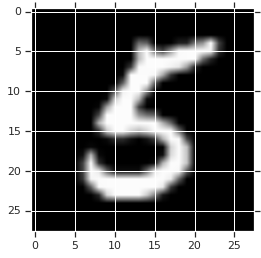

In [0]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')

### Defining a loss function

Now that we have the data, let's define a loss function that we can use for
training. First, let's define the type of input as a TFF named tuple. Since the
size of data batches may vary, we set the batch dimension to `None` to indicate
that the size of this dimension is unknown.

In [0]:
BATCH_TYPE = tff.NamedTupleType([
    ('x', tff.TensorType(tf.float32, [None, 784])),
    ('y', tff.TensorType(tf.int32, [None]))])

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

You may be wondering why we can't just define an ordinary Python type. Recall
the discussion in one of the preceding sections, where we explained that while
we can express the logic of TFF computations using Python, under the hood TFF
computations *are not* Python. The symbol `BATCH_TYPE` defined above represents
an abstract TFF type specification. It is important to distinguish this
*abstract* TFF type from concrete Python *representation* types, e.g.,
containers such as `dict` or `collections.namedtuple` that may be used to
represent the TFF type in the body of a Python function. Unlike Python, TFF has
a single abstract type constructor `tff.NamedTupleType` for tuple-like
containers, with elements that can be individually named or left unnamed. This
type is also used to model formal parameters of computations, as TFF
computations can formally only declare one parameter and one result - you will
see examples of this shortly.

Let's now define the TFF type of model parameters, again as a TFF named tuple of
*weights* and *bias*.

In [0]:
MODEL_TYPE = tff.NamedTupleType([
    ('weights', tff.TensorType(tf.float32, [784, 10])),
    ('bias', tff.TensorType(tf.float32, [10]))])

str(MODEL_TYPE)

'<weights=float32[784,10],bias=float32[10]>'

With those definitions in place, now we can define the loss for a given model, over
a single batch. Note how in the body of `batch_loss`, we access named tuple
elements using the dot (`X.Y`) notation, as is standard for TFF.

In [0]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  predicted_y = tf.nn.softmax(tf.matmul(batch.x, model.weights) + model.bias)
  return -tf.reduce_mean(tf.reduce_sum(
      tf.one_hot(batch.y, 10) * tf.log(predicted_y), reduction_indices=[1]))

As expected, computation `batch_loss` returns `float32` loss given the model and
a single data batch. Note how the `MODEL_TYPE` and `BATCH_TYPE` have been lumped
together into a 2-tuple of formal parameters; you can recognize the type of
`batch_loss` as `(<MODEL_TYPE,BATCH_TYPE> -> float32)`.

In [0]:
str(batch_loss.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>> -> float32)'

As a sanity check, let's construct an initial model filled with zeros and
compute the loss over the batch of data we visualized above.

In [0]:
initial_model = {
    'weights': np.zeros([784, 10], dtype=np.float32),
    'bias': np.zeros([10], dtype=np.float32)
}

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025854

Note that we feed the TFF computation with the initial model defined as a
`dict`, even though the body of the Python function that defines it consumes
model parameters as `model.weight` and `model.bias`. Since, as explained
earlier, the logic of a TFF computation is defined in a glue language over
abstract TFF types, the choice of a physical Python container in this case
doesn't matter. The arguments of the call to `batch_loss` aren't simply passed
to the body of that function. Indeed, if you remember the earlier discussion in
the section on federated computations, the body of `batch_loss` has already been
traced earlier - that is, *before* the invocation, not after. TFF acts as the
caller to `batch_loss` at the computation definition time, and as the target of
invocation at the time `batch_loss` is invoked. In both roles, TFF serves as the
bridge between TFF's abstract type system and Python representation types. At
the invocation time, TFF will accept most standard Python container types
(`dict`, `list`, `tuple`, `collections.namedtuple`, etc.) as concrete
representations of abstract TFF tuples. Also, although as noted above, TFF
computations formally only accept a single parameter, you can use the familiar
Python call syntax with positional and/or keyword arguments in case where the
type of the parameter is a tuple - it works as expected.

### Gradient descent on a single batch

Now, let's define a computation that uses this loss function to perform a single
step of gradient descent. Note how in defining this function, we use
`batch_loss` as a subcomponent. You can always invoke a computation constructed
with `tff.tf_computation` inside the body of another computation.

In [0]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`.
  model_vars = tff.utils.get_variables('v', MODEL_TYPE)
  init_model = tff.utils.assign(model_vars, initial_model)

  # Perform one step of gradient descent using loss from `batch_loss`.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  with tf.control_dependencies([init_model]):
    train_model = optimizer.minimize(batch_loss(model_vars, batch))

  # Return the model vars after performing this gradient descent step.
  with tf.control_dependencies([train_model]):
    return tff.utils.identity(model_vars)

In [0]:
str(batch_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>,float32> -> <weights=float32[784,10],bias=float32[10]>)'

When you invoke a Python function decorated with `tff.tf_computation` within the
body of another such function, the logic of the inner TFF computation that gets
created is embedded in the logic of the outer one. You should ideally write your
code under the assumption that the inner and outer computations are, for the
most part, opaque to each other (thus, it's best to minimize the use of features
such as graph introspection or the use of collections). We are actively
experimenting with ways to support strong isolation between the inner and outer
computations, and if you rely on graph introspection, certain patterns may
break. That said, `batch_train` as written above does rely on the ability to
trace through the `batch_loss`'s graph in order to compute the gradients.

Now, let's apply this function a few times to the initial model to see whether
the loss decreases.

In [0]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [0]:
#@test {"output": "ignore"}
losses

[0.19690022, 0.13176313, 0.10113225, 0.082738116, 0.070301391]

### Gradient descent on a sequence of local data

Now, since `batch_train` appears to work, let's write a similar training
function `local_train` that consumes the entire sequence of all batches from one
user instead of just a single batch. The new computation will need to now
consume `tff.SequenceType(BATCH_TYPE)` instead of `BATCH_TYPE`.

In [0]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
  def batch_fn(model, batch):
    return batch_train(model, batch, learning_rate)

  return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [0]:
str(local_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,float32,<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

There are quite a few details buried in this short section of code, let's go
over them one by one.

First, while we could have implemented this logic entirely in TensorFlow,
relying on `tf.data.Dataset.reduce` to process the sequence similarly to how
we've done it earlier, we've opted this time to express the logic in the glue
language, as a `tff.federated_computation`. We've used the federated operator
`tff.sequence_reduce` to perform the reduction.

The operator `tff.sequence_reduce` is used similarly to
`tf.data.Dataset.reduce`. You can think of it as a template operator with a
formal parameter 3-tuple that consists of a *sequence* of `T`-typed elements,
the initial state of the reduction (we'll refer to it abstractly as *zero*) of
some type `U`, and the *reduction operator* of type `(U,T->U)` that alters the
state of the reduction by processing a single element. The result is the final
state of the reduction, after processing all elements in a sequential order. In
our example, the state of the reduction is the model trained on a prefix of the
data, and the elements are data batches.

Second, note that we have again used one computation (`batch_train`) as a
component within another (`local_train`), but not directly. We can't use it as a
reduction operator because it takes an additional parameter - the learning rate.

To work around the fact that `batch_train` takes an additional parameter, we
define an embedded federated computation `batch_fn` that binds to the
`local_train`'s parameter `learning_rate` in its body. It is allowed for a child
computation defined this way to capture a formal parameter of its parent as long
as the child computation is not invoked outside the body of its parent. You can
think of this pattern as an equivalent of `functools.partial` in Python.

The practical implication of capturing `learning_rate` this way is, of course,
that the same learning rate value is used across all batches.

Now, let's try the newly defined local training function on the entire sequence
of data from the same user who contributed the sample batch (digit `5`).

In [0]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

Did it work? To answer this question, we need to implement evaluation.

### Local evaluation

Here's one way to implement local evaluation by adding up the losses across all data
batches (we could have just as well computed the average; we'll leave it as an
exercise for the reader).

In [0]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
  return tff.sequence_sum(
      tff.sequence_map(
          tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
          all_batches))

In [0]:
str(local_eval.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>*> -> float32)'

Again, there are a few new elements illustrated by this code, let's go over them
one by one.

First, we have used two new federated operators for processing sequences:
`tff.sequence_map` that takes a *mapping function* `T->U` and a *sequence* of
`T`, and emits a sequence of `U` obtained by applying the mapping function
pointwise, and `tff.sequence_sum` that just adds all the elements. Here, we map
each data batch to a loss value, and then add the resulting loss values to
compute the total loss.

Note that we could have again used `tff.sequence_reduce`, but this wouldn't be
the best choice - the reduction process is, by definition, sequential, whereas
the mapping and sum can be computed in parallel. When given a choice, it's best
to stick with operators that don't constrain implementation choices, so that
when our TFF computation is compiled in the future to be deployed to a specific
environment, one can take full advantage of all potential opportunities for a
faster, more scalable, more resource-efficient execution.

Second, note that just as in `local_train`, the component function we need
(`batch_loss`) takes more parameters than what the federated operator
(`tff.sequence_map`) expects - in this case, the operator wants a function that
maps batches to losses, but `batch_loss` also takes a model. Just as we did with
the learning rate, we use an embedded computation that captures the
`local_eval`'s model in its body in very much the same way we previously
captured `learning_rate` in `local_train`'s embedded computation `batch_fn`,
thus once again effectively defining a *partial* (a computation with a subset of
parameters bound, and the type signature modified to reflect this).

The one major difference compared to the previous example is that this time,
rather than defining a Python function with `tff.federated_computation` used as
a decorator, we've defined the computation inline, by invoking
`tff.federated_computation` as an ordinary function (not as a decorator), with a
Python lambda and a type signature as arguments. This inline style of defining
TFF computations mirrors the use of `lambda` expressions in Python, and can be a
good choice for short sections of code like this one.

Now, let's see whether our training worked.

In [0]:
local_eval(initial_model, federated_train_data[5])

23.025854

In [0]:
local_eval(locally_trained_model, federated_train_data[5])

0.43484691

Indeed, the loss decreased. But what happens if we evaluated it on another
user's data?

In [0]:
local_eval(initial_model, federated_train_data[0])

23.025854

In [0]:
local_eval(locally_trained_model, federated_train_data[0])

74.500748

As expected, things got worse. The model was trained to recognize `5`, and has
never seen a `0`. This brings the question - how did the local training impact
the quality of the model from the global perspective?

### Federated evaluation

This is the point in our journey where we finally circle back to federated types
and federated computations - the topic that we started with. Here's a pair of
TFF types definitions for the model that originates at the server, and the data
that remains on the clients.

In [0]:
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER, all_equal=True)
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)

With all the definitions introduced so far, expressing federated evaluation in
TFF is a one-liner - we distribute the model to clients, let each client invoke
local evaluation on its local portion of data, and then average out the loss.
Here's one way to write this.

In [0]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_average(
      tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

We've already seen examples of `tff.federated_average` and `tff.federated_map`
in simpler scenarios, and at the intuitive level, they work as expected, but
there's more in this section of code than meets the eye, so let's go over it
carefully.

First, let's break down the *let each client invoke local evaluation on its
local portion of data* part. As you may recall from the preceding sections,
`local_eval` has a type signature of the form `(<MODEL_TYPE, LOCAL_DATA_TYPE> ->
float32)`.

The federated operator `tff.federated_map` is a template that accepts as a
parameter a 2-tuple that consists of the *mapping function* of some type `T->U`
and a federated value of type `{T}@CLIENTS` (i.e., with member constituents of
the same type as the parameter of the mapping function), and returns a result of
type `{U}@CLIENTS`.

Since we're feeding `local_eval` as a mapping function to apply on a per-client
basis, the second argument should be a federated of type `<MODEL_TYPE,
LOCAL_DATA_TYPE>@CLIENTS`, i.e., in the nomenclature of the preceding sections,
it should be a federated tuple. Each client should hold a full set of arguments
for `local_eval` as a member consituent. Instead, we're feeding it a 2-element
Python `list`. What's happening here?

Indeed, this is an example of an *implicit type cast* in TFF, similar to
implicit type casts you may have encountered elsewhere, e.g., when you feed an
`int` to a function that accepts a `float`. Implicit casting is used scarcily at
this point, but we plan to make it more pervasive in TFF as a way to minimize
boilerplate.

The implicit cast that's applied in this case is the equivalence between
federated tuples of the form `<X,Y>@Z`, and tuples of federated values
`<X@Z,Y@Z>`. While formally, these two are different type signatures, looking at
it from the programmers's perspective, each device in `Z` holds two units of
data `X` and `Y`. What happens here is not unlike `zip` in Python, and indeed,
we offer an operator `tff.federated_zip` that allows you to perform such
conversions explicity. When the `tff.federated_map` encounters a tuple as a
second argument, it simply invokes `tff.federated_zip` for you.

Given the above, you should now be able to recognize the expression
`tff.federated_broadcast(model)` as representing a value of TFF type
`{MODEL_TYPE}@CLIENTS`, and `data` as a value of TFF type
`{LOCAL_DATA_TYPE}@CLIENTS` (or simply `CLIENT_DATA_TYPE`), the two getting
filtered together through an implicit `tff.federated_zip` to form the second
argument to `tff.federated_map`.

The operator `tff.federated_broadcast`, as you'd expect, simply transfers data
from the server to the clients.

Now, let's see how our local training affected the average loss in the system.

In [0]:
federated_eval(initial_model, federated_train_data)

23.025852

In [0]:
federated_eval(locally_trained_model, federated_train_data)

54.432625

Indeed, as expected, the loss has increased. In order to improve the model for
all users, we'll need to train in on everyone's data.

### Federated training

The simplest way to implement federated training is to locally train, and then
average the models. This uses the same building blocks and patters we've already
discussed, as you can see below.

In [0]:
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER, all_equal=True)

@tff.federated_computation(
    SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE, CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_average(
      tff.federated_map(
          local_train,
          [tff.federated_broadcast(model),
           tff.federated_broadcast(learning_rate),
           data]))

In reality, rather than averaging the models, we prefer to average model deltas,
for a number of reasons, e.g., such as the ability to clip their norms, for
compression, etc. This is a trivial change in TFF, as you'll just need to
subtract the model from the argument to `tff.federated_average`, and then add it
back to the result. We'll leave this change as an exercise for the user.

Let's see whether the training works by running a few rounds of training and
comparing the average loss before and after.

In [0]:
#@test {"timeout": 600}
model = initial_model
learning_rate = 0.1
losses = []
for _ in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  losses.append(federated_eval(model, federated_train_data))

In [0]:
#@test {"output": "ignore"}
losses

[21.605524, 20.365679, 19.274801, 18.31111, 17.457254]

For completeness, let's now also run on the test data to confirm that our model
generalizes well.

In [0]:
federated_eval(initial_model, federated_test_data)

22.795593

In [0]:
federated_eval(model, federated_test_data)

17.278767

Of course, our simplified example doesn't capture everything you'd need to do in
a more realistic scenario - for example, we haven't computed metrics other than
loss, and we only ran it for a few rounds. Those topics will be covered in
follow-up tutorials.